# IMPORTS

In [1]:
# Do Imports
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai
from fastai import train as tr

import pickle
import matplotlib as mpl

In [2]:
os.chdir('../HEPAutoencoders')
from nn_utils import AE_big, AE_3D_200
from utils import plot_activations
import my_matplotlib_style as ms
# mpl.rc_file('../HEPAutoencoders/my_matplotlib_rcparams')

In [3]:
'''CHECKING FOR GPU'''

print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

True


# LOADING DATA

In [4]:
'''LOAD DATA'''

train = pd.read_pickle('../data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('../data/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

In [5]:
train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [6]:
test.head(5)

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


In [7]:
'''Normalizing the Data'''

# Calculate the train mean/standard-dev
# Use it to normalize train/test.
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x 
test_y = test_x

In [8]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(111778, 4) (111778, 4)
(27945, 4) (27945, 4)


In [9]:
'''Make DataLoaders'''

# Generate Datasets.
train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

# Instantiate train/valid dataloaders.
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=512)

# TRAINING

- Unlike model1 and model2, here we train using a constant learning rate. 
- Also we don't plot graphs to estimate the optimal learning rate.

In [10]:
import time
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import f1_score, accuracy_score

In [19]:
# Set up the model

model = AE_3D_200().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Set monitoring lists

iterr_count = 0
epoch_count = 0

iter_list = []
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

In [21]:
inspect_size = 20
batch_size = 256
n_iters = int((len(train) / batch_size) * num_epochs)
n_inspects = int(len(train) / (batch_size*inspect_size))

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False, precision=4)

# print("Batch Size       : ", batch_size)
# print("Learning Rate    : ", learning_rate)
# print("Number of Epochs : ", num_epochs)
# print("Iterations/Epoch : ", len(train_loader), len(valid_loader))
# print("Inspects/Epoch   : ", n_inspects)

In [22]:
# Set training parameters I

monitor_iter = True
monitor_train = True
monitor_train_preds = False
eval_length = 5
monitor_valid = True
monitor_valid_preds = False
save_bset = False

In [23]:
# Set training parameters II

learning_rate = 3e-4
num_epochs = 60
inspect_size = 20

In [24]:
'''Train the Model'''

time_start = time.time()

soft = torch.nn.Softmax(dim=1) 
train_labels = np.array([])
train_preds = np.array([])

len_train_batches = len(train_loader)
len_valid_batches = len(valid_loader)
init_epoch_count = epoch_count

for epoch in range(num_epochs):
    epoch_count += 1
    print("===============================================================================================================")
    
    it_train_loader = iter(train_loader)
    
    model.train()
    for iteration in tqdm_notebook(range(len_train_batches)):
        iterr_count += 1

        images, labels = next(it_train_loader)
        images = images.type(torch.float).to(device)
        labels = labels.type(torch.float).to(device)
        
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        if(monitor_train):
            preds = preds.detach().cpu().numpy()
            labels = labels.cpu().numpy()
            train_preds = np.append(train_preds, preds)
            train_labels = np.append(train_labels, labels)

        # ---------------------------------------------------------------------------------------------
        ####################################### Validation #######################################
        if(iteration % inspect_size != 0): continue

        if(monitor_iter):
            print("[{:2d}/{:2d}] Iteration: {:3d} [{:3.0f}%]".format(epoch_count, num_epochs+init_epoch_count, iteration, (iteration/len_train_batches) * 100, iteration))
            print("------------------------")
            iter_list.append(iterr_count)
        
        if(save_bset): print(" - BValid f1: {:0.4f}".format(best_yet_f1))
            
        if(monitor_train):
            train_loss = loss.item()
            train_loss_list.append(train_loss)
            print("[Train] Loss: {:0.4f}".format(train_loss))
            if(not monitor_train_preds):
                train_labels = np.array([])
                train_preds = np.array([])  

        if(monitor_valid):
            model.eval()
            valid_labels = np.array([])
            valid_preds = np.array([])
            
            it_valid_loader = iter(valid_loader)

            for iteration in range(len_valid_batches):
                with torch.no_grad():

                    images, labels = next(it_valid_loader)
                    images = images.type(torch.float).to(device)
                    labels = labels.to(device)
                    preds = model(images)
                    
                    loss = criterion(preds, labels)

                    preds = preds.detach().cpu().numpy()
                    labels = labels.to('cpu').numpy()

                    valid_labels = np.append(valid_labels, labels)
                    valid_preds = np.append(valid_preds, preds)

                    if(eval_length != None and iteration == eval_length): 
                        break 

            valid_loss = loss.item()
            valid_loss_list.append(valid_loss)

            print("[Valid] Loss: {:0.4f}".format(valid_loss))
            
            if(save_bset and valid_f1 > best_yet_f1):
                best_yet_f1 = valid_f1
                torch.save(model.state_dict(), "best_yet.pt")
                print("########### Saved best model ###########")
        
        if(monitor_train_preds):
            print("Train Target : ", train_labels[:24])
            print("Train Preds  : ", train_preds[:24])
            train_labels = np.array([])
            train_preds = np.array([])

        if(monitor_valid_preds):
            print("Valid Target : ", valid_labels[:24])
            print("Valid Preds  : ", valid_preds[:24])

        print("==========================================")

time_end = time.time()
print("Time taken : ", time_end-time_start)

/home/black/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[ 1/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 1.0279
[Valid] Loss: 0.9861
[ 1/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.5613
[Valid] Loss: 0.5732
[ 1/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.1621
[Valid] Loss: 0.1806
[ 1/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.1529
[Valid] Loss: 0.1398
[ 1/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0954
[Valid] Loss: 0.1135
[ 1/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0828
[Valid] Loss: 0.0930
[ 1/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0744
[Valid] Loss: 0.0784
[ 1/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0740
[Valid] Loss: 0.0677
[ 1/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0462
[Valid] Loss: 0.0601
[ 1/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0521
[Valid] Loss: 0.0539
[ 1/60] Iteration: 200 [ 46%]


[ 2/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0298
[Valid] Loss: 0.0367
[ 2/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0388
[Valid] Loss: 0.0365
[ 2/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0549
[Valid] Loss: 0.0362
[ 2/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0252
[Valid] Loss: 0.0363
[ 2/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0360
[Valid] Loss: 0.0363
[ 2/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0342
[Valid] Loss: 0.0359
[ 2/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0220
[Valid] Loss: 0.0354
[ 2/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0316
[Valid] Loss: 0.0355
[ 2/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0335
[Valid] Loss: 0.0355
[ 2/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0310
[Valid] Loss: 0.0352
[ 2/60] Iteration: 200 [ 46%]


[ 3/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0305
[Valid] Loss: 0.0338
[ 3/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0399
[Valid] Loss: 0.0337
[ 3/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0375
[Valid] Loss: 0.0341
[ 3/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0317
[Valid] Loss: 0.0336
[ 3/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0339
[Valid] Loss: 0.0338
[ 3/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0259
[Valid] Loss: 0.0336
[ 3/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0372
[Valid] Loss: 0.0331
[ 3/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0232
[Valid] Loss: 0.0333
[ 3/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0304
[Valid] Loss: 0.0332
[ 3/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0278
[Valid] Loss: 0.0332
[ 3/60] Iteration: 200 [ 46%]


[ 4/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0363
[Valid] Loss: 0.0324
[ 4/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0254
[Valid] Loss: 0.0323
[ 4/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0306
[Valid] Loss: 0.0324
[ 4/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0262
[Valid] Loss: 0.0320
[ 4/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0294
[Valid] Loss: 0.0322
[ 4/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0249
[Valid] Loss: 0.0320
[ 4/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0358
[Valid] Loss: 0.0322
[ 4/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0366
[Valid] Loss: 0.0319
[ 4/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0308
[Valid] Loss: 0.0324
[ 4/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0309
[Valid] Loss: 0.0320
[ 4/60] Iteration: 200 [ 46%]


[ 5/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0206
[Valid] Loss: 0.0314
[ 5/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0389
[Valid] Loss: 0.0310
[ 5/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0391
[Valid] Loss: 0.0304
[ 5/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0380
[Valid] Loss: 0.0305
[ 5/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0297
[Valid] Loss: 0.0304
[ 5/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0283
[Valid] Loss: 0.0305
[ 5/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0249
[Valid] Loss: 0.0302
[ 5/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0341
[Valid] Loss: 0.0301
[ 5/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0329
[Valid] Loss: 0.0301
[ 5/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0220
[Valid] Loss: 0.0303
[ 5/60] Iteration: 200 [ 46%]


[ 6/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0262
[Valid] Loss: 0.0293
[ 6/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0239
[Valid] Loss: 0.0293
[ 6/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0204
[Valid] Loss: 0.0295
[ 6/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0270
[Valid] Loss: 0.0289
[ 6/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0390
[Valid] Loss: 0.0287
[ 6/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0267
[Valid] Loss: 0.0291
[ 6/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0203
[Valid] Loss: 0.0287
[ 6/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0466
[Valid] Loss: 0.0286
[ 6/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0334
[Valid] Loss: 0.0293
[ 6/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0385
[Valid] Loss: 0.0290
[ 6/60] Iteration: 200 [ 46%]


[ 7/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0354
[Valid] Loss: 0.0279
[ 7/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0256
[Valid] Loss: 0.0283
[ 7/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0383
[Valid] Loss: 0.0278
[ 7/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0358
[Valid] Loss: 0.0282
[ 7/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0232
[Valid] Loss: 0.0277
[ 7/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0196
[Valid] Loss: 0.0282
[ 7/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0315
[Valid] Loss: 0.0277
[ 7/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0277
[ 7/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0215
[Valid] Loss: 0.0278
[ 7/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0576
[Valid] Loss: 0.0276
[ 7/60] Iteration: 200 [ 46%]


[ 8/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0228
[Valid] Loss: 0.0267
[ 8/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0498
[Valid] Loss: 0.0270
[ 8/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0338
[Valid] Loss: 0.0271
[ 8/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0176
[Valid] Loss: 0.0268
[ 8/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0242
[Valid] Loss: 0.0272
[ 8/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0188
[Valid] Loss: 0.0267
[ 8/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0252
[Valid] Loss: 0.0270
[ 8/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0262
[Valid] Loss: 0.0267
[ 8/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0266
[Valid] Loss: 0.0269
[ 8/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0270
[Valid] Loss: 0.0267
[ 8/60] Iteration: 200 [ 46%]


[ 9/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0198
[Valid] Loss: 0.0259
[ 9/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0227
[Valid] Loss: 0.0264
[ 9/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0263
[ 9/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0205
[Valid] Loss: 0.0262
[ 9/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0184
[Valid] Loss: 0.0259
[ 9/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0224
[Valid] Loss: 0.0263
[ 9/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0223
[Valid] Loss: 0.0263
[ 9/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0257
[ 9/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0261
[ 9/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0303
[Valid] Loss: 0.0259
[ 9/60] Iteration: 200 [ 46%]


[10/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0213
[Valid] Loss: 0.0260
[10/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0192
[Valid] Loss: 0.0256
[10/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0451
[Valid] Loss: 0.0258
[10/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0211
[Valid] Loss: 0.0261
[10/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0264
[Valid] Loss: 0.0260
[10/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0269
[Valid] Loss: 0.0259
[10/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0251
[Valid] Loss: 0.0257
[10/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0277
[Valid] Loss: 0.0256
[10/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0239
[Valid] Loss: 0.0255
[10/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0255
[10/60] Iteration: 200 [ 46%]


[11/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0181
[Valid] Loss: 0.0253
[11/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0224
[Valid] Loss: 0.0254
[11/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0230
[Valid] Loss: 0.0251
[11/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0246
[Valid] Loss: 0.0249
[11/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0318
[Valid] Loss: 0.0248
[11/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0236
[Valid] Loss: 0.0249
[11/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0236
[Valid] Loss: 0.0249
[11/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0217
[Valid] Loss: 0.0248
[11/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0227
[Valid] Loss: 0.0248
[11/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0218
[Valid] Loss: 0.0251
[11/60] Iteration: 200 [ 46%]


[12/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0275
[Valid] Loss: 0.0243
[12/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0195
[Valid] Loss: 0.0242
[12/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0719
[Valid] Loss: 0.0238
[12/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0240
[12/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0219
[Valid] Loss: 0.0233
[12/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0296
[Valid] Loss: 0.0241
[12/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0205
[Valid] Loss: 0.0237
[12/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0359
[Valid] Loss: 0.0236
[12/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0241
[12/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0239
[Valid] Loss: 0.0239
[12/60] Iteration: 200 [ 46%]


[13/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0272
[Valid] Loss: 0.0230
[13/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0279
[Valid] Loss: 0.0226
[13/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0209
[Valid] Loss: 0.0225
[13/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0252
[Valid] Loss: 0.0228
[13/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0227
[13/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0221
[13/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0262
[Valid] Loss: 0.0225
[13/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0309
[Valid] Loss: 0.0227
[13/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0313
[Valid] Loss: 0.0230
[13/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0293
[Valid] Loss: 0.0226
[13/60] Iteration: 200 [ 46%]


[14/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0375
[Valid] Loss: 0.0225
[14/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0301
[Valid] Loss: 0.0220
[14/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0227
[14/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0238
[Valid] Loss: 0.0225
[14/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0197
[Valid] Loss: 0.0218
[14/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0245
[Valid] Loss: 0.0224
[14/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0244
[Valid] Loss: 0.0213
[14/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0247
[Valid] Loss: 0.0213
[14/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0217
[14/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0267
[Valid] Loss: 0.0214
[14/60] Iteration: 200 [ 46%]


[15/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0233
[Valid] Loss: 0.0213
[15/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0170
[Valid] Loss: 0.0220
[15/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0212
[15/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0198
[Valid] Loss: 0.0214
[15/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0226
[Valid] Loss: 0.0211
[15/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0177
[Valid] Loss: 0.0212
[15/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0342
[Valid] Loss: 0.0208
[15/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0211
[15/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0167
[Valid] Loss: 0.0208
[15/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0224
[Valid] Loss: 0.0213
[15/60] Iteration: 200 [ 46%]


[16/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0210
[Valid] Loss: 0.0208
[16/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0211
[Valid] Loss: 0.0211
[16/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0173
[Valid] Loss: 0.0207
[16/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0194
[Valid] Loss: 0.0208
[16/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0249
[Valid] Loss: 0.0210
[16/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0195
[Valid] Loss: 0.0207
[16/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0216
[Valid] Loss: 0.0206
[16/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0148
[Valid] Loss: 0.0204
[16/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0177
[Valid] Loss: 0.0206
[16/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0222
[Valid] Loss: 0.0206
[16/60] Iteration: 200 [ 46%]


[17/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0141
[Valid] Loss: 0.0204
[17/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0221
[Valid] Loss: 0.0198
[17/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0173
[Valid] Loss: 0.0199
[17/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0165
[Valid] Loss: 0.0201
[17/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0205
[Valid] Loss: 0.0205
[17/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0198
[17/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0276
[Valid] Loss: 0.0205
[17/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0335
[Valid] Loss: 0.0199
[17/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0208
[17/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0189
[Valid] Loss: 0.0200
[17/60] Iteration: 200 [ 46%]


[18/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0234
[Valid] Loss: 0.0206
[18/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0198
[18/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0198
[Valid] Loss: 0.0197
[18/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0195
[18/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0195
[18/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0141
[Valid] Loss: 0.0207
[18/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0352
[Valid] Loss: 0.0201
[18/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0170
[Valid] Loss: 0.0198
[18/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0326
[Valid] Loss: 0.0199
[18/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0180
[Valid] Loss: 0.0193
[18/60] Iteration: 200 [ 46%]


[19/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0252
[Valid] Loss: 0.0197
[19/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0212
[Valid] Loss: 0.0192
[19/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0202
[Valid] Loss: 0.0197
[19/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0184
[Valid] Loss: 0.0201
[19/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0264
[Valid] Loss: 0.0197
[19/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0203
[Valid] Loss: 0.0190
[19/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0225
[Valid] Loss: 0.0198
[19/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0196
[19/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0200
[19/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0207
[Valid] Loss: 0.0187
[19/60] Iteration: 200 [ 46%]


[20/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0164
[Valid] Loss: 0.0197
[20/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0191
[20/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0209
[Valid] Loss: 0.0187
[20/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0183
[20/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0180
[Valid] Loss: 0.0180
[20/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0206
[Valid] Loss: 0.0179
[20/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0146
[Valid] Loss: 0.0183
[20/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0185
[Valid] Loss: 0.0197
[20/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0118
[Valid] Loss: 0.0201
[20/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0168
[Valid] Loss: 0.0207
[20/60] Iteration: 200 [ 46%]


[21/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0207
[Valid] Loss: 0.0189
[21/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0223
[Valid] Loss: 0.0183
[21/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0187
[21/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0176
[Valid] Loss: 0.0182
[21/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0189
[Valid] Loss: 0.0185
[21/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0268
[Valid] Loss: 0.0184
[21/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0185
[21/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0264
[Valid] Loss: 0.0184
[21/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0232
[Valid] Loss: 0.0186
[21/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0161
[Valid] Loss: 0.0183
[21/60] Iteration: 200 [ 46%]


[22/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0168
[Valid] Loss: 0.0184
[22/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0139
[Valid] Loss: 0.0181
[22/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0156
[Valid] Loss: 0.0184
[22/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0240
[Valid] Loss: 0.0190
[22/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0108
[Valid] Loss: 0.0184
[22/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0206
[Valid] Loss: 0.0182
[22/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0120
[Valid] Loss: 0.0184
[22/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0190
[22/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0185
[Valid] Loss: 0.0183
[22/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0185
[22/60] Iteration: 200 [ 46%]


[23/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0199
[Valid] Loss: 0.0180
[23/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0162
[Valid] Loss: 0.0181
[23/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0178
[23/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0173
[23/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0220
[Valid] Loss: 0.0175
[23/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0177
[Valid] Loss: 0.0182
[23/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0235
[Valid] Loss: 0.0179
[23/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0208
[Valid] Loss: 0.0180
[23/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0177
[23/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0203
[Valid] Loss: 0.0179
[23/60] Iteration: 200 [ 46%]


[24/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0221
[Valid] Loss: 0.0172
[24/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0169
[24/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0159
[Valid] Loss: 0.0170
[24/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0177
[Valid] Loss: 0.0171
[24/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0190
[Valid] Loss: 0.0169
[24/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0170
[24/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0122
[Valid] Loss: 0.0171
[24/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0201
[Valid] Loss: 0.0168
[24/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0172
[Valid] Loss: 0.0171
[24/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0173
[24/60] Iteration: 200 [ 46%]


[25/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0215
[Valid] Loss: 0.0173
[25/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0159
[Valid] Loss: 0.0176
[25/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0175
[25/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0241
[Valid] Loss: 0.0175
[25/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0168
[Valid] Loss: 0.0172
[25/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0173
[25/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0153
[Valid] Loss: 0.0171
[25/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0222
[Valid] Loss: 0.0172
[25/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0220
[Valid] Loss: 0.0175
[25/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0179
[25/60] Iteration: 200 [ 46%]


[26/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0213
[Valid] Loss: 0.0187
[26/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0170
[26/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0174
[26/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0168
[26/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0170
[26/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0168
[Valid] Loss: 0.0166
[26/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0184
[Valid] Loss: 0.0168
[26/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0171
[26/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0195
[Valid] Loss: 0.0167
[26/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0192
[Valid] Loss: 0.0171
[26/60] Iteration: 200 [ 46%]


[27/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0176
[27/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0164
[Valid] Loss: 0.0180
[27/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0175
[27/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0218
[Valid] Loss: 0.0181
[27/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0180
[27/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0181
[27/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0155
[Valid] Loss: 0.0188
[27/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0177
[27/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0240
[Valid] Loss: 0.0176
[27/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0207
[Valid] Loss: 0.0173
[27/60] Iteration: 200 [ 46%]


[28/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0162
[Valid] Loss: 0.0169
[28/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0162
[28/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0165
[28/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0150
[Valid] Loss: 0.0165
[28/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0174
[28/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0186
[Valid] Loss: 0.0176
[28/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0289
[Valid] Loss: 0.0174
[28/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0174
[28/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0139
[Valid] Loss: 0.0172
[28/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0195
[Valid] Loss: 0.0176
[28/60] Iteration: 200 [ 46%]


[29/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0202
[Valid] Loss: 0.0213
[29/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0230
[Valid] Loss: 0.0201
[29/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0199
[29/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0171
[Valid] Loss: 0.0178
[29/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0175
[29/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0190
[29/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0185
[29/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0233
[Valid] Loss: 0.0193
[29/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0208
[29/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0215
[29/60] Iteration: 200 [ 46%]


[30/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0170
[Valid] Loss: 0.0171
[30/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0171
[30/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0170
[30/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0165
[Valid] Loss: 0.0172
[30/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0176
[30/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0231
[Valid] Loss: 0.0179
[30/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0176
[30/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0159
[Valid] Loss: 0.0195
[30/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0187
[Valid] Loss: 0.0188
[30/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0290
[Valid] Loss: 0.0171
[30/60] Iteration: 200 [ 46%]


[31/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0125
[Valid] Loss: 0.0177
[31/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0177
[31/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0171
[Valid] Loss: 0.0180
[31/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0152
[Valid] Loss: 0.0175
[31/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0203
[Valid] Loss: 0.0173
[31/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0117
[Valid] Loss: 0.0172
[31/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0131
[Valid] Loss: 0.0182
[31/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0187
[31/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0173
[Valid] Loss: 0.0190
[31/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0155
[Valid] Loss: 0.0212
[31/60] Iteration: 200 [ 46%]


[32/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0225
[32/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0163
[Valid] Loss: 0.0181
[32/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0180
[Valid] Loss: 0.0211
[32/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0199
[Valid] Loss: 0.0205
[32/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0203
[32/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0195
[32/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0153
[Valid] Loss: 0.0182
[32/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0189
[32/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0182
[32/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0180
[32/60] Iteration: 200 [ 46%]


[33/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0165
[33/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0235
[Valid] Loss: 0.0163
[33/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0155
[Valid] Loss: 0.0168
[33/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0188
[Valid] Loss: 0.0206
[33/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0160
[Valid] Loss: 0.0193
[33/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0175
[Valid] Loss: 0.0181
[33/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0187
[33/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0196
[33/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0205
[33/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0206
[33/60] Iteration: 200 [ 46%]


[34/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0152
[Valid] Loss: 0.0201
[34/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0206
[Valid] Loss: 0.0186
[34/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0191
[34/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0230
[Valid] Loss: 0.0168
[34/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0187
[34/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0202
[34/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0171
[Valid] Loss: 0.0197
[34/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0349
[Valid] Loss: 0.0170
[34/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0195
[Valid] Loss: 0.0165
[34/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0133
[Valid] Loss: 0.0161
[34/60] Iteration: 200 [ 46%]


[35/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0176
[35/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0164
[Valid] Loss: 0.0205
[35/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0218
[35/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0164
[35/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0161
[35/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0166
[35/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0184
[35/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0093
[Valid] Loss: 0.0232
[35/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0218
[35/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0177
[Valid] Loss: 0.0201
[35/60] Iteration: 200 [ 46%]


[36/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0147
[Valid] Loss: 0.0159
[36/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0113
[Valid] Loss: 0.0163
[36/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0184
[Valid] Loss: 0.0171
[36/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0193
[Valid] Loss: 0.0167
[36/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0166
[36/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0174
[36/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0107
[Valid] Loss: 0.0167
[36/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0162
[Valid] Loss: 0.0169
[36/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0178
[36/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0115
[Valid] Loss: 0.0183
[36/60] Iteration: 200 [ 46%]


[37/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0179
[Valid] Loss: 0.0201
[37/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0185
[37/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0155
[Valid] Loss: 0.0232
[37/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0207
[37/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0209
[37/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0182
[37/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0114
[Valid] Loss: 0.0188
[37/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0107
[Valid] Loss: 0.0168
[37/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0169
[37/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0221
[37/60] Iteration: 200 [ 46%]


[38/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0119
[Valid] Loss: 0.0175
[38/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0098
[Valid] Loss: 0.0166
[38/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0174
[38/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0164
[38/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0152
[Valid] Loss: 0.0172
[38/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0164
[38/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0129
[Valid] Loss: 0.0161
[38/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0147
[Valid] Loss: 0.0169
[38/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0162
[38/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0218
[Valid] Loss: 0.0161
[38/60] Iteration: 200 [ 46%]


[39/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0139
[Valid] Loss: 0.0167
[39/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0141
[Valid] Loss: 0.0172
[39/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0160
[Valid] Loss: 0.0164
[39/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0169
[39/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0194
[Valid] Loss: 0.0180
[39/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0202
[Valid] Loss: 0.0179
[39/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0191
[Valid] Loss: 0.0171
[39/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0109
[Valid] Loss: 0.0170
[39/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0169
[39/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0120
[Valid] Loss: 0.0163
[39/60] Iteration: 200 [ 46%]


[40/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0214
[Valid] Loss: 0.0166
[40/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0125
[Valid] Loss: 0.0160
[40/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0119
[Valid] Loss: 0.0158
[40/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0157
[40/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0090
[Valid] Loss: 0.0160
[40/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0162
[40/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0181
[40/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0179
[Valid] Loss: 0.0162
[40/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0170
[40/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0133
[Valid] Loss: 0.0167
[40/60] Iteration: 200 [ 46%]


[41/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0108
[Valid] Loss: 0.0168
[41/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0166
[41/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0130
[Valid] Loss: 0.0171
[41/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0125
[Valid] Loss: 0.0210
[41/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0129
[Valid] Loss: 0.0212
[41/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0197
[41/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0118
[Valid] Loss: 0.0175
[41/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0131
[Valid] Loss: 0.0193
[41/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0221
[41/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0114
[Valid] Loss: 0.0189
[41/60] Iteration: 200 [ 46%]


[42/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0154
[Valid] Loss: 0.0177
[42/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0121
[Valid] Loss: 0.0184
[42/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0188
[Valid] Loss: 0.0161
[42/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0147
[Valid] Loss: 0.0160
[42/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0156
[42/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0161
[42/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0164
[42/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0140
[Valid] Loss: 0.0158
[42/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0107
[Valid] Loss: 0.0169
[42/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0116
[Valid] Loss: 0.0155
[42/60] Iteration: 200 [ 46%]


[43/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0147
[Valid] Loss: 0.0156
[43/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0095
[Valid] Loss: 0.0154
[43/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0183
[Valid] Loss: 0.0152
[43/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0141
[Valid] Loss: 0.0153
[43/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0123
[Valid] Loss: 0.0148
[43/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0152
[43/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0156
[43/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0163
[43/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0087
[Valid] Loss: 0.0154
[43/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0107
[Valid] Loss: 0.0158
[43/60] Iteration: 200 [ 46%]


[44/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0169
[44/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0165
[44/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0125
[Valid] Loss: 0.0179
[44/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0161
[44/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0113
[Valid] Loss: 0.0173
[44/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0168
[44/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0173
[44/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0182
[44/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0130
[Valid] Loss: 0.0159
[44/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0113
[Valid] Loss: 0.0196
[44/60] Iteration: 200 [ 46%]


[45/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0169
[45/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0163
[45/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0121
[Valid] Loss: 0.0186
[45/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0188
[Valid] Loss: 0.0172
[45/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0076
[Valid] Loss: 0.0169
[45/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0178
[45/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0119
[Valid] Loss: 0.0175
[45/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0171
[45/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0171
[45/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0109
[Valid] Loss: 0.0188
[45/60] Iteration: 200 [ 46%]


[46/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0125
[Valid] Loss: 0.0164
[46/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0162
[46/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0157
[46/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0169
[46/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0160
[Valid] Loss: 0.0174
[46/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0180
[Valid] Loss: 0.0158
[46/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0101
[Valid] Loss: 0.0157
[46/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0156
[46/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0111
[Valid] Loss: 0.0158
[46/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0102
[Valid] Loss: 0.0157
[46/60] Iteration: 200 [ 46%]


[47/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0157
[Valid] Loss: 0.0172
[47/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0116
[Valid] Loss: 0.0180
[47/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0153
[Valid] Loss: 0.0167
[47/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0112
[Valid] Loss: 0.0164
[47/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0170
[47/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0166
[47/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0106
[Valid] Loss: 0.0165
[47/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0148
[Valid] Loss: 0.0166
[47/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0171
[47/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0164
[Valid] Loss: 0.0163
[47/60] Iteration: 200 [ 46%]


[48/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0085
[Valid] Loss: 0.0154
[48/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0130
[Valid] Loss: 0.0153
[48/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0082
[Valid] Loss: 0.0161
[48/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0156
[Valid] Loss: 0.0161
[48/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0154
[48/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0123
[Valid] Loss: 0.0156
[48/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0159
[Valid] Loss: 0.0153
[48/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0147
[Valid] Loss: 0.0156
[48/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0171
[48/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0100
[Valid] Loss: 0.0160
[48/60] Iteration: 200 [ 46%]


[49/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0108
[Valid] Loss: 0.0151
[49/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0142
[Valid] Loss: 0.0158
[49/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0186
[Valid] Loss: 0.0155
[49/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0153
[49/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0131
[Valid] Loss: 0.0151
[49/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0154
[Valid] Loss: 0.0155
[49/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0105
[Valid] Loss: 0.0155
[49/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0154
[49/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0149
[49/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0118
[Valid] Loss: 0.0156
[49/60] Iteration: 200 [ 46%]


[50/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0154
[Valid] Loss: 0.0190
[50/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0131
[Valid] Loss: 0.0157
[50/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0164
[50/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0157
[50/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0113
[Valid] Loss: 0.0171
[50/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0156
[50/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0249
[Valid] Loss: 0.0161
[50/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0139
[Valid] Loss: 0.0147
[50/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0189
[Valid] Loss: 0.0159
[50/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0173
[Valid] Loss: 0.0166
[50/60] Iteration: 200 [ 46%]


[51/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0160
[Valid] Loss: 0.0154
[51/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0166
[Valid] Loss: 0.0158
[51/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0159
[Valid] Loss: 0.0164
[51/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0185
[51/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0102
[Valid] Loss: 0.0191
[51/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0188
[Valid] Loss: 0.0188
[51/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0186
[Valid] Loss: 0.0196
[51/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0154
[51/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0152
[51/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0210
[Valid] Loss: 0.0154
[51/60] Iteration: 200 [ 46%]


[52/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0208
[Valid] Loss: 0.0151
[52/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0126
[Valid] Loss: 0.0144
[52/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0148
[52/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0152
[52/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0111
[Valid] Loss: 0.0159
[52/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0150
[Valid] Loss: 0.0170
[52/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0098
[Valid] Loss: 0.0163
[52/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0144
[Valid] Loss: 0.0149
[52/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0147
[52/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0200
[Valid] Loss: 0.0149
[52/60] Iteration: 200 [ 46%]


[53/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0156
[Valid] Loss: 0.0148
[53/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0151
[53/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0150
[53/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0099
[Valid] Loss: 0.0149
[53/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0152
[Valid] Loss: 0.0152
[53/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0168
[Valid] Loss: 0.0149
[53/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0146
[53/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0115
[Valid] Loss: 0.0144
[53/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0137
[Valid] Loss: 0.0148
[53/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0101
[Valid] Loss: 0.0173
[53/60] Iteration: 200 [ 46%]


[54/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0102
[Valid] Loss: 0.0164
[54/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0130
[Valid] Loss: 0.0162
[54/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0173
[Valid] Loss: 0.0165
[54/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0162
[54/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0084
[Valid] Loss: 0.0185
[54/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0139
[Valid] Loss: 0.0181
[54/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0129
[Valid] Loss: 0.0162
[54/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0114
[Valid] Loss: 0.0170
[54/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0135
[Valid] Loss: 0.0186
[54/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0158
[54/60] Iteration: 200 [ 46%]


[55/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0175
[Valid] Loss: 0.0158
[55/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0174
[Valid] Loss: 0.0155
[55/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0075
[Valid] Loss: 0.0157
[55/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0153
[55/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0128
[Valid] Loss: 0.0164
[55/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0149
[Valid] Loss: 0.0174
[55/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0172
[55/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0115
[Valid] Loss: 0.0172
[55/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0134
[Valid] Loss: 0.0165
[55/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0115
[Valid] Loss: 0.0175
[55/60] Iteration: 200 [ 46%]


[56/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0151
[Valid] Loss: 0.0138
[56/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0164
[Valid] Loss: 0.0142
[56/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0132
[Valid] Loss: 0.0148
[56/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0110
[Valid] Loss: 0.0165
[56/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0112
[Valid] Loss: 0.0157
[56/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0108
[Valid] Loss: 0.0157
[56/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0135
[Valid] Loss: 0.0154
[56/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0156
[56/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0152
[56/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0157
[56/60] Iteration: 200 [ 46%]


[57/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0112
[Valid] Loss: 0.0149
[57/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0148
[57/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0105
[Valid] Loss: 0.0148
[57/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0178
[Valid] Loss: 0.0159
[57/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0100
[Valid] Loss: 0.0155
[57/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0081
[Valid] Loss: 0.0162
[57/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0166
[57/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0241
[Valid] Loss: 0.0155
[57/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0122
[Valid] Loss: 0.0176
[57/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0094
[Valid] Loss: 0.0176
[57/60] Iteration: 200 [ 46%]


[58/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0119
[Valid] Loss: 0.0159
[58/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0176
[Valid] Loss: 0.0139
[58/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0106
[Valid] Loss: 0.0148
[58/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0138
[Valid] Loss: 0.0166
[58/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0124
[Valid] Loss: 0.0156
[58/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0135
[Valid] Loss: 0.0170
[58/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0129
[Valid] Loss: 0.0165
[58/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0169
[Valid] Loss: 0.0176
[58/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0158
[Valid] Loss: 0.0154
[58/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0145
[Valid] Loss: 0.0158
[58/60] Iteration: 200 [ 46%]


[59/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0131
[Valid] Loss: 0.0161
[59/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0095
[Valid] Loss: 0.0173
[59/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0171
[59/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0155
[59/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0092
[Valid] Loss: 0.0173
[59/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0105
[Valid] Loss: 0.0156
[59/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0126
[Valid] Loss: 0.0161
[59/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0121
[Valid] Loss: 0.0162
[59/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0109
[Valid] Loss: 0.0154
[59/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0166
[59/60] Iteration: 200 [ 46%]


[60/60] Iteration:   0 [  0%]
------------------------
[Train] Loss: 0.0096
[Valid] Loss: 0.0143
[60/60] Iteration:  20 [  5%]
------------------------
[Train] Loss: 0.0109
[Valid] Loss: 0.0151
[60/60] Iteration:  40 [  9%]
------------------------
[Train] Loss: 0.0100
[Valid] Loss: 0.0150
[60/60] Iteration:  60 [ 14%]
------------------------
[Train] Loss: 0.0136
[Valid] Loss: 0.0146
[60/60] Iteration:  80 [ 18%]
------------------------
[Train] Loss: 0.0133
[Valid] Loss: 0.0149
[60/60] Iteration: 100 [ 23%]
------------------------
[Train] Loss: 0.0127
[Valid] Loss: 0.0149
[60/60] Iteration: 120 [ 27%]
------------------------
[Train] Loss: 0.0116
[Valid] Loss: 0.0139
[60/60] Iteration: 140 [ 32%]
------------------------
[Train] Loss: 0.0092
[Valid] Loss: 0.0144
[60/60] Iteration: 160 [ 37%]
------------------------
[Train] Loss: 0.0103
[Valid] Loss: 0.0139
[60/60] Iteration: 180 [ 41%]
------------------------
[Train] Loss: 0.0143
[Valid] Loss: 0.0146
[60/60] Iteration: 200 [ 46%]


In [57]:
'''Getting valid loss for whole validation dataset'''

it_valid_loader = iter(valid_loader)
loss_list = []

for iteration in range(len_valid_batches):
    with torch.no_grad():

        images, labels = next(it_valid_loader)
        images = images.type(torch.float).to(device)
        labels = labels.to(device)
        preds = model(images)

        loss = criterion(preds, labels)
        valid_loss = loss.item()
        loss_list.append(valid_loss)
        
valid_loss = np.mean(loss_list)
valid_loss

0.012641605437571033

# SAVING AND LOADING

In [50]:
# Save the model to 'models' folder

val_loss = "0.012641"

os.chdir("../model3_custom_pytorch")
torch.save(model.state_dict(), 'models/model3_weights_loss=' + val_loss +'.pt')

# Save the loss lists.
# Useful in plotting and analysing graphs later on.
mdict = {}
list_name = ['train_loss_list', 'valid_loss_list']
for i in range(len(list_name)):
    mdict[list_name[i]] = eval(list_name[i])  

fileObject = open('models/model3_dict_loss='+val_loss+'.pkl','wb')
pickle.dump(mdict,fileObject)   
fileObject.close()

In [51]:
# Load the saved model

val_loss = "0.012641"

os.chdir("../model3_custom_pytorch")
model.load_state_dict(torch.load(
                            'models/model3_weights_loss=' + val_loss + '.pt', 
                            map_location=torch.device('cpu')
                        ))

fileObject = open('models/model3_dict_loss='+val_loss+'.pkl','rb')
mdictx = pickle.load(fileObject)  

train_loss_list = mdictx['train_loss_list']
valid_loss_list = mdictx['valid_loss_list']

# EVALUATION : TRAINED AUTOENCODER

In [52]:
'''VALIDATION MSE'''

print("Validation MSE for trained model: ", valid_loss)

Validation MSE for trained model:  0.012641605437571033


In [53]:
'''HELPER FUNCTIONS'''

def encode(x):
    '''
    Encode the input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).float()
    en = model.encode(x).detach()
    return en

def decode(x):
    '''
    Decode the input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).float()
    en = model.decode(x).detach()
    return en

def predict(x):
    '''
    Predict the reconstructed vector 
    for input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).float()
    y = model(x).detach()
    return y

def relativeError(x):
    '''
    Returns the relative absolute error between
    the input vector `x` and its reconstruction,
    summed over all dimensions.
    '''
    x = torch.Tensor(x).float()
    y = model(x).detach()
    error = sum(abs((x-y)/x)).item()
    return error

In [54]:
'''EVALUATING RANDOM INPUT'''

input1 = [1,2,3,4]
pred1 = predict(input1)
# print(input1, pred1)
print(relativeError(input1))

1.649879813194275


In [55]:
'''EVALUATING ACTUAL INPUT'''

input2 = train.values[0]
pred2 = predict(input2)
# print(input2, pred2)
print(relativeError(input2))

0.06075214222073555


# GRAPHS

NOTE : All plots correspond to model with `loss=0.012641`.

In [39]:
os.chdir("../model3_custom_pytorch")

In [40]:
'''CALCULATING STATISTICS'''

# Send model to cpu
model.to('cpu')

# Get predictions
data = torch.tensor(test_x.values)
pred = model(data.float()).detach().numpy()

# "Un-normalize" the data
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

# "Un-normalize" the predictions
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)

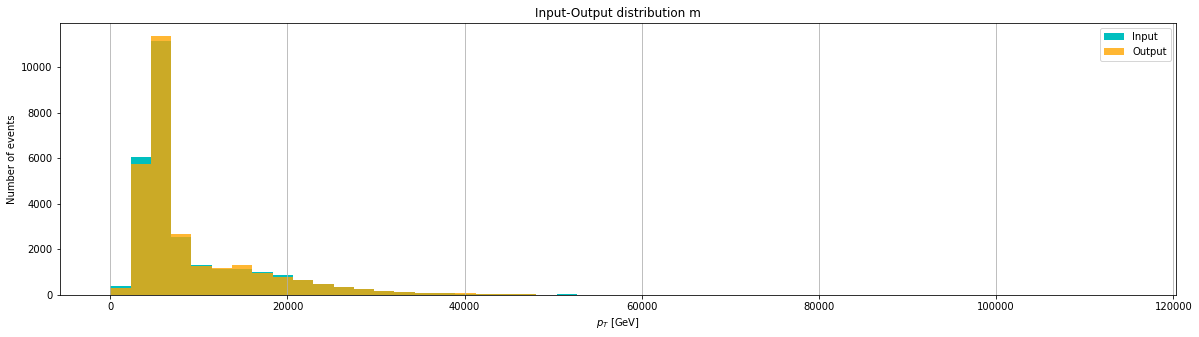

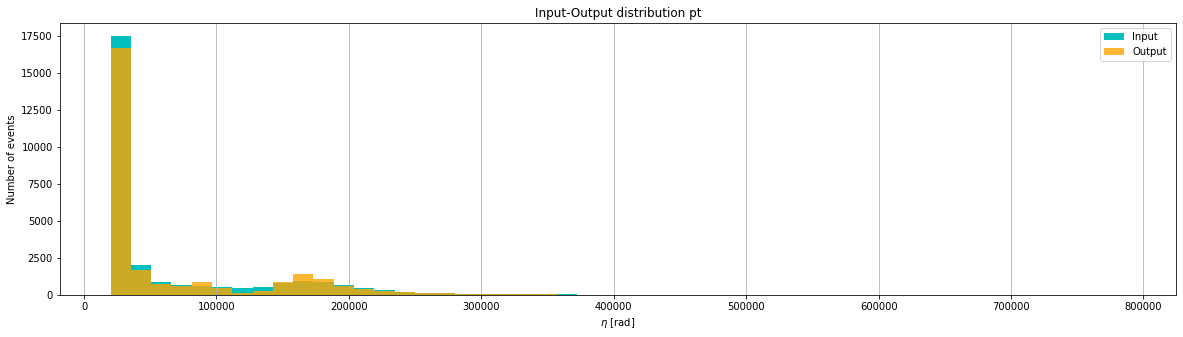

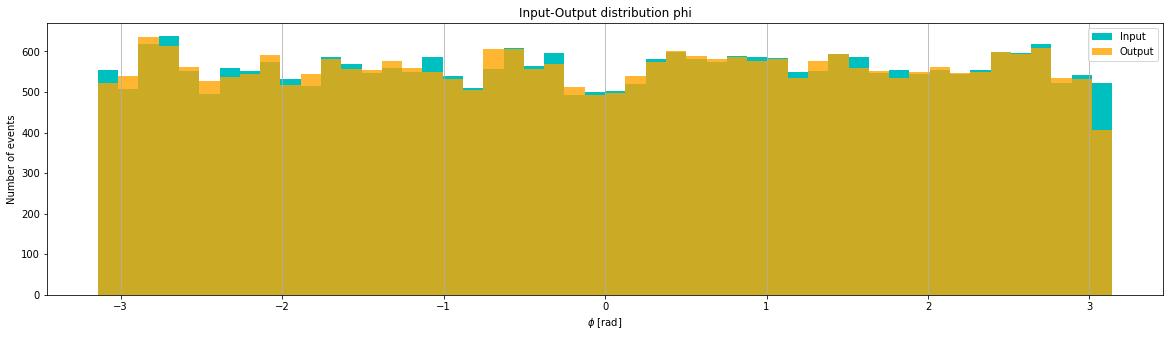

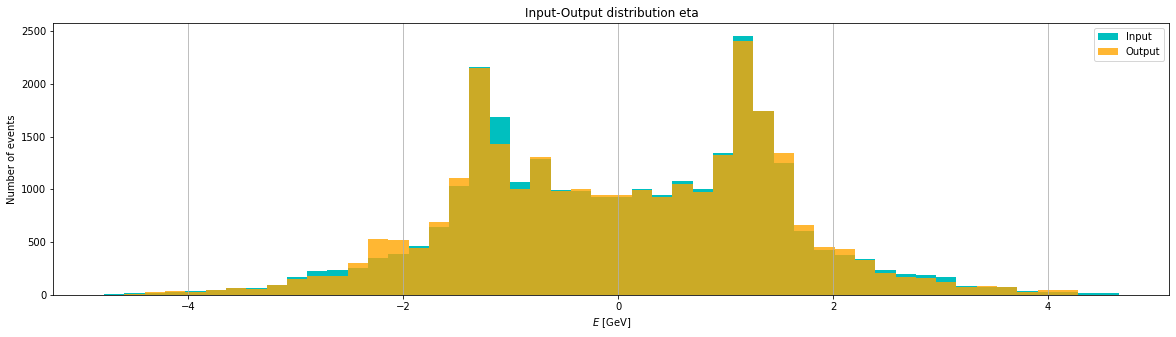

In [41]:
'''PLOTTING DISTRIBUTION HISTOGRAMS'''

# Close previous Plots
plt.close('all')

# Define data variables
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

# Define data variable units
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']

# Other graph params
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.8
n_bins = 50

for idx in np.arange(4):
    fig_name = "Input-Output distribution " + train_x.columns[idx]
    plt.figure(figsize=[20,5])
    
    # Plot input histogram
    n_hist_data, bin_edges, _ = plt.hist(data[:,idx], color=colors[1], label='Input', alpha=1, bins=n_bins)
    
    # Plot output histogram
    n_hist_pred, _, _ = plt.hist(pred[:,idx], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    # Set misc. graph setings
    plt.title(fig_name)                                    # Set title
    plt.xlabel(variable_list[idx] + ' ' + unit_list[idx])  # Set label for x-axis
    plt.ylabel('Number of events')                         # Set label for y-asix
    plt.grid(axis='x')                                     # Set grid
    plt.legend()                                           # Set legend
    
    # Save figures
    plt.savefig("graphs/Input-Output_distribution_" + train_x.columns[idx] + ".png", dpi=200)
    
    # Show figures
    plt.show()

/home/black/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/black/.local/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/black/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


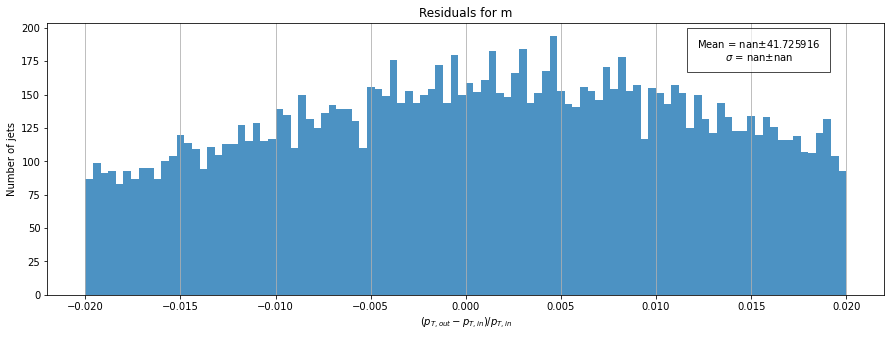

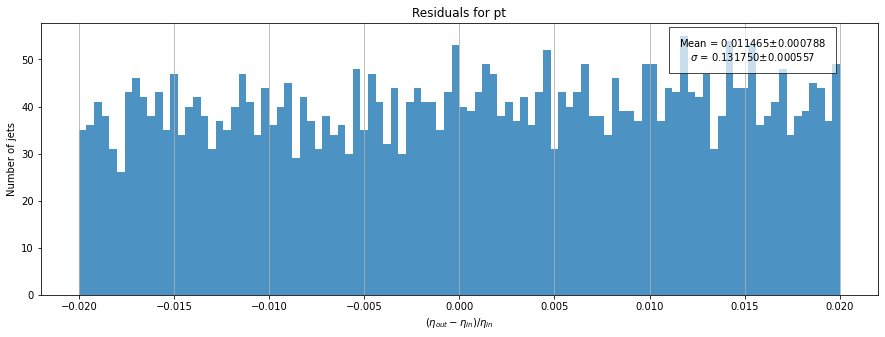

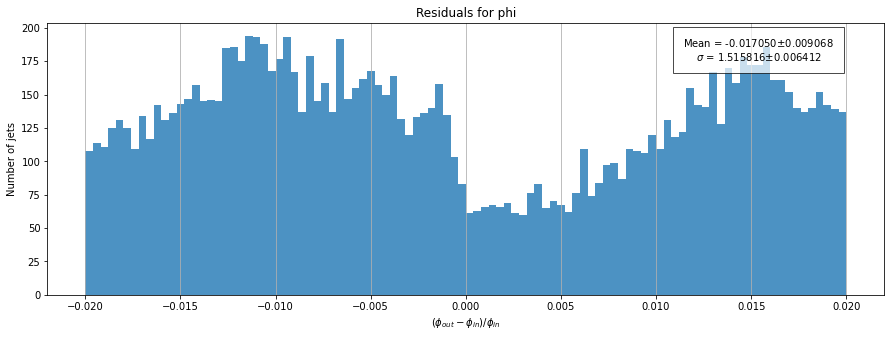

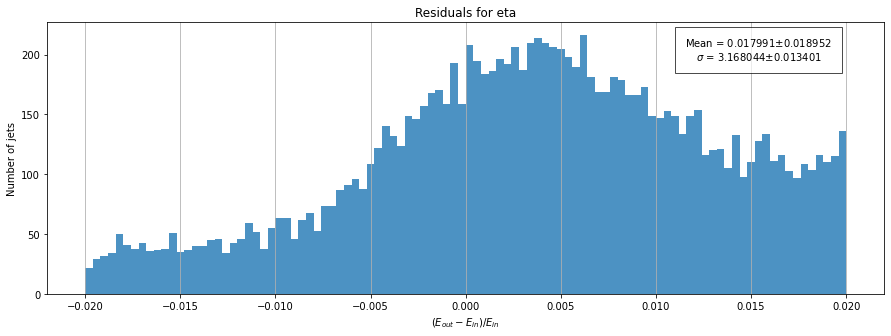

In [42]:
'''PLOTTING RESIDUALS'''

import utils
from scipy import stats

# Labels for x-axes
residual_strings = [
                r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                r'$(E_{out} - E_{in}) / E_{in}$'
            ]

# Calculate residuals
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
resRange = (-.02, .02)

for idx in np.arange(4):
    plt.figure(figsize=[15,5])
    
    # Plot residual histograms.
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, idx], 
        label='Residuals', 
        linestyle=line_style[0], 
        alpha=alph, 
        bins=100, 
        range=resRange
    )
    
    # Set misc. graph setings
    fig_name = 'Residuals for ' + train.columns[idx]
    plt.title(fig_name)
    plt.xlabel(residual_strings[idx]) 
    plt.ylabel('Number of jets')
    plt.grid(axis='x')

    # Calculate residual statistics for text box
    std = np.std(residuals[:, idx])                       # Get standard-dev
    std_err = utils.std_error(residuals[:, idx])          # Get standard error in standard-dev
    mean = np.nanmean(residuals[:, idx])                  # Get mean
    sem = stats.sem(residuals[:, idx], nan_policy='omit') # Get standard error of mean
    ax = plt.gca()
    
    # Add text box with stats
    plt.text(
        .85, .9, 
        'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), 
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes, 
        fontsize=10
    )
    
    # Save Graph
    plt.savefig("graphs/Residuals_" + train_x.columns[idx] + ".png", dpi=200)

    # Show Graph
    plt.show()

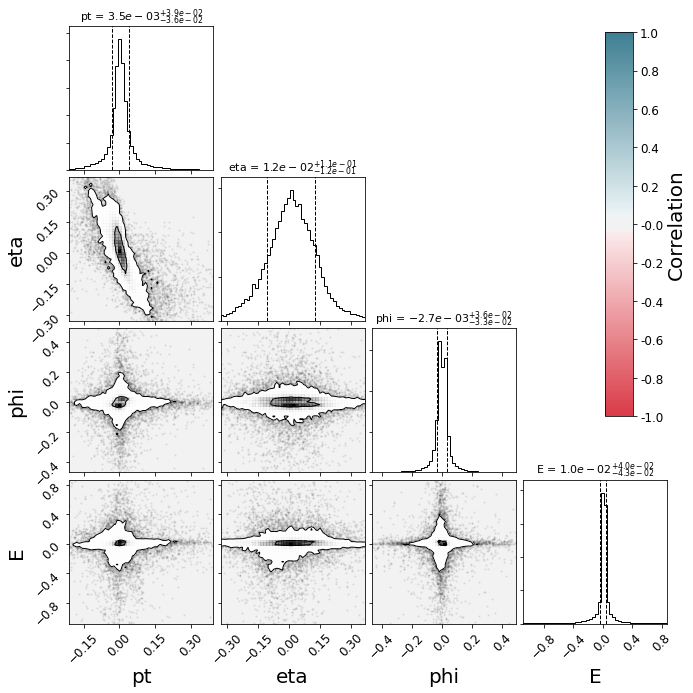

In [46]:
'''PLOTTING CORRELATIONS'''

import corner.corner as corner
import seaborn as sns

# Build residual dataframe
res_df = pd.DataFrame({
    'pt': residuals[:, 0], 
    'eta': residuals[:, 1], 
    'phi': residuals[:, 2], 
    'E': residuals[:, 3]
})

# Build correlation matrix
group_arr = res_df.values
corr = res_df.corr()

# Get values at secific quantiles from each variable.
quantileVal = [.01, .99]         #### Best for our Data : correlations2
# quantileVal = [.005, .995]       #### Intermediate : correlations1
# quantileVal = [.0025, .9975]     #### Original choice : correlations0

qs = np.quantile(group_arr, q=quantileVal, axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, var]) for var in np.arange(ndim)]

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Arguments passed later
label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}

group = ['pt', 'eta', 'phi', 'E']
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# Refer : https://corner.readthedocs.io/en/latest/api.html#corner.corner
figure = corner(
    group_arr, 
    range=ranges, 
    plot_density=True, 
    plot_contours=True, 
    no_fill_contours=False, 
    bins=50, 
    labels=group, 
    show_titles=True, 
    label_kwargs=label_kwargs, 
    title_kwargs=title_kwargs, 
    quantiles=(0.16, 0.84),
    levels = (1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e'
)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
# linecol = 'r'
# linstyl = 'dashed'

# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))

# Add colour-bar
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

# Save the figure
plt.savefig('graphs/correlations2.png', dpi=200)

# Show the figure
plt.show()

In [33]:
'''GENERATING AVERAGE INSPECTION LISTS'''

# Defining roll function
def make_roll(input_list, roll_size=5):
    output_list = []
    
    for i in range(len(input_list)):
        if i==0:
            output_list.append(input_list[0])
        elif i<roll_size:
            output_list.append(np.mean(input_list[:i+1]))
        else:
            output_list.append(np.mean(input_list[i-roll_size:i]))
    return output_list

# Generating roll lists
train_roll_loss_list = make_roll(train_loss_list, roll_size=5) 
train_roll_acc_list = make_roll(train_acc_list, roll_size=5)  

valid_roll_acc_list = make_roll(valid_acc_list, roll_size=5)  
valid_roll_loss_list = make_roll(valid_loss_list, roll_size=5)  

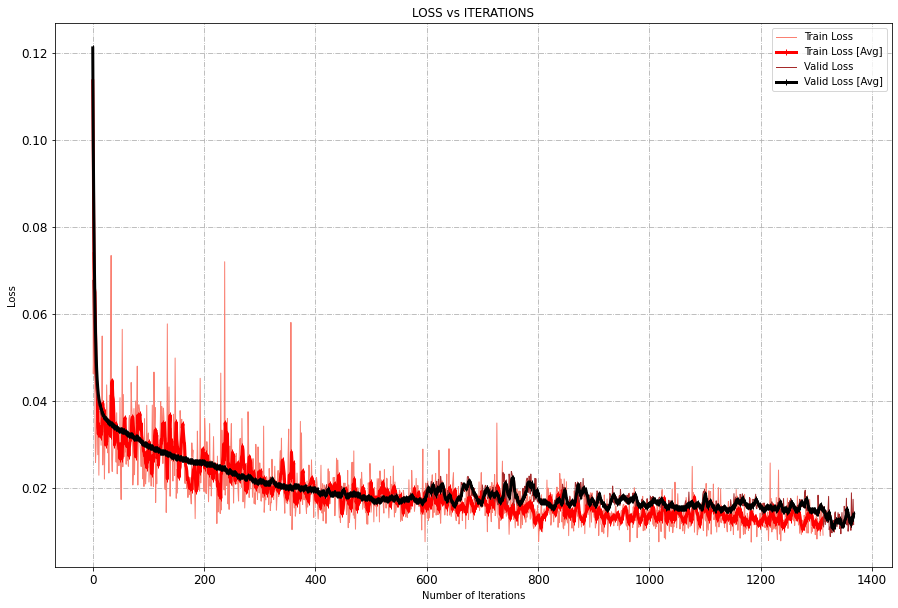

In [56]:
'''PLOTTTING THE LOSS GRAPH'''

# Make figure
plt.figure(figsize=[15,10])

# Number of first few datapoints to ignore.
# Necessary to avoid a skewed graph.
offset = 7

# Plot train losses
plt.plot(train_loss_list[offset:], '-', lw=1, c='salmon', label='Train Loss')
plt.plot(train_roll_loss_list[offset:], '-|r', lw=3, label='Train Loss [Avg]')

# Plot valid losses
plt.plot(valid_loss_list[offset:], '-', lw=1, c='brown', label='Valid Loss')
plt.plot(valid_roll_loss_list[offset:], '-|k', lw=3, label='Valid Loss [Avg]')

plt.title('LOSS vs ITERATIONS')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.grid(True, linestyle='-.',)
plt.tick_params()
plt.legend()

# Save Graph
plt.savefig("graphs/loss.png", dpi=200)

# Show Graph
plt.show()